In [1]:
!pip3 install numpy matplotlib

# Linear Regression Two ways

1. The Analytical Solution  
2. By Gradient Descent

#### Prerequisites: Calculus, Linear Algebra

In [2]:
# Import depedencies
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**First we make a toy dataset by creating a function that:**
1. Randomly initializes a line 
2. Randomly samples points in the domain
3. Returns an array of the points on the line with added gaussian noise

**Additionally, we make a visualization function that plots the dataset**

In [3]:
def generate_data(size, mean=10.0, std=5.0):
    """Returns a toy linear dataset (x,y)
    """
    # randomly initialize a line
    m, b = np.random.randn(2)
    
    # Generate arrays to be sampled from
    x = np.linspace(-size // 2, size // 2, size)
    y = m * x + b
    
    # Add noise to the y output
    noise = np.random.normal(mean, std, size=size)
    sampled_y = y + noise
    
    return x, sampled_y

def show_dataset(x, y, lines=[]):
    """Plots a dataset and an arbitrary number of input lines
    """
    plt.scatter(x, y, c='r')
    plt.xlim(min(x), max(x))
    for line in lines:
        plt.plot(x, line[0], label=line[1])
    plt.legend()
    plt.show()

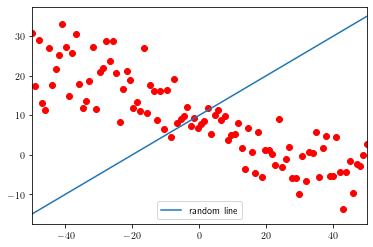

In [9]:
xdata, ydata = generate_data(100, std=5)
lines = [(0.5*xdata+10, 'random line')]
show_dataset(xdata, ydata, lines)

$\newcommand{\x}{X}$
$\newcommand{\L}{\mathcal{L}}$
$\newcommand{\t}{\theta}$
$\newcommand{\yh}{\hat{\textbf{y}}}$
$\newcommand{\y}{\textbf{y}}$
## Method 1: Analytical Solution
* Equation of a line  <br>
$$ \hat{y} = mx + b $$  <br>
         
* This method computes the optimal parameters for the linear model in one-shot. <br>
    1. In matrix-vector form, the linear equation is:  <br><br>
$$
\yh = \x\t\qquad\t\in{\mathbb{R}^{n+1},\quad\x\in{\mathbb{R}^{m\times(n+1)}}}
$$<br>
Where $\x$ is a matrix of features with 1 appended to the end and $\t$ is a vector of parameters with the bias appended to the end. <br><br>
        
    2. Mean-squared-error Loss function - This is desirable since MSE is convex i.e. it has a global minimum. <br>  
        $$ L = \frac{1}{2}\sum_{i=1}^{N} (y_i-\hat{y}_i)^2 = \frac{1}{2} \| \textbf{y} - \hat{\textbf{y}} \|^{2}_2
             = \frac{1}{2}\| \y - \x\t\|^{2}_2 = \frac{1}{2}(\y-\x\t)^\top (\y - \x\t)$$  <br><br>
* Now we can can go about deriving the analytical solution by solving the following optimization program: <br><br>
$$ \min_\t \L(\x,\y;\t) $$ <br>
This is called Empirical Risk Minimization (ERM).

    1. The first step is to expand the loss function and leave out the constant factor in front for convenience:<br>
    
        $$ \L = \frac{1}{2}((\y^\top - (\x\t)^\top)(\y - \x\t)$$ <br>
        $$ \hspace{0.4cm} = \frac{1}{2}(\y^\top \y-\y^\top (\x\t) -(\x\t)^\top \y+ (\x\t)^\top \x\t)$$ <br>
        $$ \hspace{0.4cm} = \frac{1}{2}(\y^\top \y-\y^\top (\x\t) -\t^\top \x^\top \y+ \t^\top\x^\top \x\t)$$ <br>
        $$ \hspace{0.4cm} = \frac{1}{2}(\t^\top \x^\top\x\t-2\y^\top \x\t+\y^\top \y )$$ <br>
        
    2. Now we use some results of matrix calculus <br><br>
        $$\frac{\partial{(\x\t)}}{\partial{\t}} = \x^T, \quad\frac{\partial({\t^\top M\t)}}{\partial{\t}}=M\t+M^\top \t$$ <br>
        <br>
    3. We can now finish the derivation for the optimal $\t$ by computing $\frac{\partial{\L}}{\partial{\t}}$ and setting it equal to zero: <br>
        
        $$\frac{\partial{\L}}{\partial{\t}}\Bigr\rvert_{\t=\t} = \frac{1}{2}\x^\top \x\t+\frac{1}{2}(\x^\top \x)^\top \t-\x^\top \y= \x^\top (\x\t - \y)$$<br>
        $$\x^\top \x\t^* -\x^\top \y = 0$$<br>
        $$\x^\top \x\t^{*}=\x^\top \y$$<br>
        $$\t^{*}=(\x^\top \x)^{-1}\x^\top \y$$ <br><br>
        
    4. The expression $A^+ = (\x^\top \x)^{-1}\x^\top$ from above is also known as the [Moore-Penrose Psuedoinverse](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.9-The-Moore-Penrose-Pseudoinverse/). It is used to approximately solve linear equations of the form $Ax=b$ with $AA^+\approx I$ (in the case that $A^{-1}$ may not exist)

    
* Finally, lets write the code to implement this:

In [13]:
# Reshape a copy of x into a matrix with a 1's column appended to it
X = np.c_[xdata[:], np.ones(xdata.shape)]
print(X[20:30])  # Show a few entries to get the idea

[[-29.7979798    1.        ]
 [-28.78787879   1.        ]
 [-27.77777778   1.        ]
 [-26.76767677   1.        ]
 [-25.75757576   1.        ]
 [-24.74747475   1.        ]
 [-23.73737374   1.        ]
 [-22.72727273   1.        ]
 [-21.71717172   1.        ]
 [-20.70707071   1.        ]]


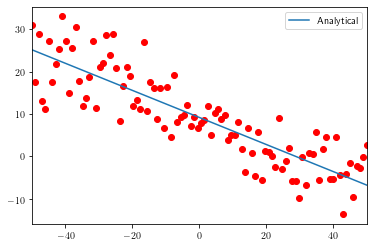

In [15]:
# Finally just apply the equation using numpy! 
# Note: The output will be a [2,1] vector containing m and b
params = np.linalg.inv(X.T@X)@X.T@ydata

show_dataset(xdata, ydata, [(X@params, "Analytical")])

## Method 2: Gradient Descent

* First lets define a few things: <br>
    1. Equation of a line  <br><br>
        - Standard form: $ \hat{y} = mx + b $  <br><br>
        - Matrix-vector form: $\hat{\textbf{y}} = X \theta$ <br><br>
         
    2. Mean-squared-error Loss function - This is desirable since MSE is convex i.e. it has a global minimum. <br>  
        $$ L = \frac{1}{2}\sum_{i=1}^{N} (y_i-\hat{y}_i)^2 = \frac{1}{2} \| \textbf{y} - \hat{\textbf{y}} \|^{2}_2$$  <br><br>
          
    3. Gradient Descent Rule - This is how the parameters get updated such that the loss is minimized.  <br><br>
        $$ \theta := \theta - \alpha \nabla_\theta \mathcal{L} $$ <br>

* Here is a picture of what gradient descent is doing:

![alt text](https://saugatbhattarai.com.np/wp-content/uploads/2018/06/gradient-descent-1.jpg "Logo Title Text 1")

* All we need to do is use the gradient w.r.t. the parameters we calculated from Method 1:  <br><br> 
$$\nabla_\theta \mathcal{L} = \x^\top (\x\t - \y)$$ <br><br>

* Now we have the tools to perform linear regression by gradient descent:

In [16]:
def mseloss(value, target):
    """Computes the mean squared error (MSE) loss function
    """
    return 0.5 * np.linalg.norm(target - value)**2

def gradient_descent(X, ys, epochs, lr, num_lines=4):
    """Implements gradient descent on a dataset to reduce the MSE loss
    """
    # Initialize the parameters
    theta = np.random.rand(2)
    
    # Unpack the dataset and begin fitting
    lines = []
    for epoch in range(epochs):
        
        gradient = X.T @ (X @ theta - ys)
        theta -= lr * gradient
            
        # Computed the updated predictions
        predictions = X @ theta
            
        # Add lines to plot and print the loss
        if epoch % int(epochs / num_lines) == 0:
            lines.append((predictions, f'epoch {epoch}'))
            print(f"Epoch: {epoch:4d} MSE Loss: {mseloss(predictions, ys):.4f}")
        
    #Show the fitted lines
    show_dataset(X[:, 0], ys, lines)
    
    return X @ theta

Epoch:    0 MSE Loss: 38529.9448
Epoch:  125 MSE Loss: 3592.0061
Epoch:  250 MSE Loss: 2763.9011
Epoch:  375 MSE Loss: 2261.8814


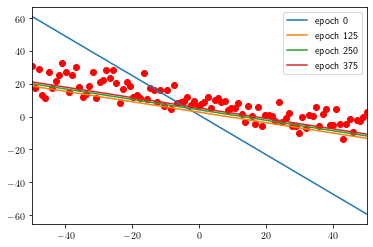

In [17]:
# Run gradient descent
y_pred = gradient_descent(X, ydata, epochs=500, lr=2e-5, num_lines=4)

Analytical solution loss: 1489.0048
Gradient descent loss: 1959.4233


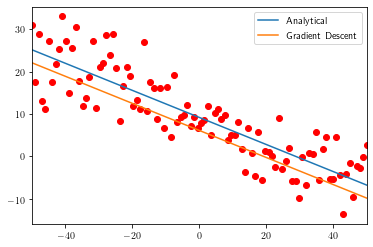

In [20]:
# Looking at the loss compared to the gradient descent method
y_hat = X @ params
analytical_loss = mseloss(y_hat, ydata)
grad_descent_loss = mseloss(y_pred, ydata)
print("Analytical solution loss: {0:.4f}\nGradient descent loss: {1:.4f}".format(
    analytical_loss, grad_descent_loss
))

lines = [
    (y_hat, "Analytical"),
    (y_pred, "Gradient Descent")
]
show_dataset(xdata, ydata, lines)

Even after 500 iterations, the analytical solution beats the gradient descent solution!